In [2]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
#     context='paper',
#     font_scale=8/8.8,
    context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [3]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule

/home/pstjohn/Research/rlmolecule/examples/stable_radical_optimization/notebooks


# Initial Results
Eagle is really backed up, so these results are from multiple runs on the debug queue (which has a 1 hr time limit)

In [4]:
import rdkit

In [5]:
# run_id = 'stable_radical_optimization'
from rlmolecule.sql.run_config import RunConfig
run_config = RunConfig('../config/config_eagle_c.yaml')
run_config.run_id

'stable_rad_c_tautomers_noembed2'

In [6]:
# load the games played
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore

engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()
df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_config.run_id).statement, session.bind)

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
df = df.sort_values('time_hours')
df_games = df
df_games.reset_index(drop=True, inplace=True)
df_games.head()

,id,run_id,time,raw_reward,scaled_reward,search_statistics,execution_statistics,time_hours
0,9a74d0db-ad9f-4862-b004-69d0b10d3573,stable_rad_c_tautomers_noembed2,2021-06-29 20:47:35.200686,0.0,0.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 18.294331550598145, 'execution_...",0.000000
1,1499225e-5998-42b6-9be3-725dcadec037,stable_rad_c_tautomers_noembed2,2021-06-29 20:47:36.374046,0.0,1.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 24.638490200042725, 'execution_...",0.000326
2,47a2c5c2-ac56-45c2-bce7-ef854a47831c,stable_rad_c_tautomers_noembed2,2021-06-29 20:47:36.506251,0.0,0.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 17.372315645217896, 'execution_...",0.000363
3,d938c21b-3172-4683-b14c-f19523c3ce7f,stable_rad_c_tautomers_noembed2,2021-06-29 20:47:36.528877,0.0,0.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 18.073183298110962, 'execution_...",0.000369
4,daac091c-ac92-43bc-b927-d41695243257,stable_rad_c_tautomers_noembed2,2021-06-29 20:47:36.681856,0.0,1.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 18.674891471862793, 'execution_...",0.000411


In [7]:
df_games.shape

(5406, 8)

In [8]:
df_games.iloc[-1]['execution_statistics']

{'total_time': 946.8520121574402,
 'execution_time': {'get_next_actions': 799.5027546882629,
  'get_value_and_policy': 52.37338423728943,
  '_evaluate': 941.2875349521637,
  'calc_reward': 24.622361183166504,
  'maybe_store_state': 1.6310644149780273},
 'execution_count': {'get_next_actions': 6435,
  'get_value_and_policy': 4328,
  '_evaluate': 8500,
  'calc_reward': 1651,
  'maybe_store_state': 416}}

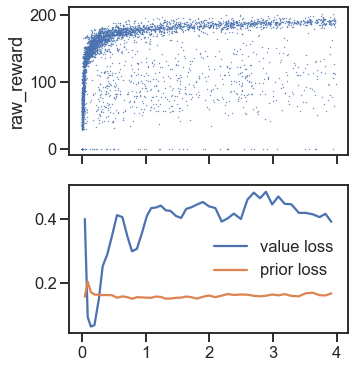

In [9]:
df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_config.run_id).statement, session.bind)
df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
df = df.sort_values('time_hours')

policy_dir = os.path.join(run_config.train_config.get('policy_checkpoint_dir', 'policy_checkpoints'), run_config.run_id)
log = pd.read_csv(os.path.join(policy_dir, "log.csv"))
log['time'] = pd.to_datetime(log.time) - df.time.min()
log['time_hours'] = (log.time).apply(lambda x: x.total_seconds() / 3600)

f, ax = plt.subplots(nrows=2, sharex=True, figsize=(5,6))

ax[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
ax[0].set_ylabel("raw_reward")

ax[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
ax[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')
# ax.set_xlabel("Epoch")
plt.legend()

In [10]:
time = pd.json_normalize(df.execution_statistics.values.tolist())
time_sum = time.sum()
time_sum['execution_time.get_next_actions'] / time_sum['execution_count.get_next_actions']

0.2634301836455014

Text(0.5, 0, 'Run time, minutes')

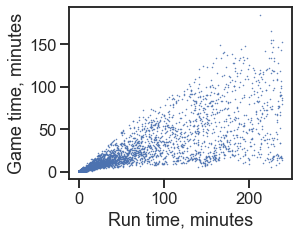

In [11]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

plt.plot(df.time_hours * 60, time.total_time / 60, '.', ms=1)

plt.ylabel('Game time, minutes')
plt.xlabel('Run time, minutes')

In [12]:
len(df.iloc[time.total_time.idxmax()]['search_statistics'])

15

In [13]:
digests = [a[0] for a in df.iloc[time.total_time.idxmax()]['search_statistics']]
df_states = pd.read_sql(session.query(StateStore).filter_by(run_id=run_config.run_id).filter(StateStore.digest.in_(
    digests)).statement, session.bind)

In [14]:
from rlmolecule.molecule.molecule_state import MoleculeState

In [15]:
[len(a[1]) for a in df.iloc[time.total_time.idxmax()]['search_statistics']]

[10, 12, 2, 11, 17, 18, 14, 28, 17, 19, 25, 22, 33, 26, 30]

In [16]:
df_states.set_index('digest').reindex(digests).state.apply(MoleculeState.deserialize)

digest
a323322f10ab649b203db742294f7b2d47a7101e987db08540c9ad5e2fe4a089                                     C
f81081f80459df7078bf5947b6a08792006f14cdb3af17613f03e6be0ceea30d                                   C=N
528031ce78c5446da41ad90c8bb772f131afc7adb67f5858a1b874cbb3644659                                  C=NC
fe1b148db069ddced9adba0621153a0d16296a727041ad7a180abffa8675d0c5                                 CC=NC
a9df8f2129d5173087504e4d18cc9383a8de1c6c961cf6df56eae3648c23e2a5                              CN=C(C)C
2f45246b1031e09dc521ab5f461b94626ab056e31100002c06cc50b30e0c55b2                             CC(C)=NCN
d75c533f5f155c3122992c4a6735f00124fff14823058b65e7b7bb1e58e02e28                         CC(=N)N=C(C)C
990d6cc3a3d6950cb6c99e2fea7278618a0921d1842e1e4cff9c8baa68c676ae                        Cc1c[nH]c(C)n1
2e9df6c60d5cc97e038fda6552035975329d532b23f0e5c19be4762700152c09                      Cc1nc(C=N)c[nH]1
0479c41217cf8a7cf6efa5115e072bb3f818ad262262d0553ce6b661171a374c  

# Measure the spin, buried volume, and draw the molecule

TODO: Need to join the tables, and unpickle the state to get the smile strings from the state

In [49]:
# look at some of the top rewards
df_rewards = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_config.run_id).filter(RewardStore.reward >= 190).statement,
                 session.bind)

df_rewards.shape

(7919, 6)

In [48]:
session.query(RewardStore).filter_by(run_id=run_config.run_id).count()

3120886

In [50]:
df_rewards['smiles'] = df_rewards.data.apply(lambda x: x['smiles'])
df_rewards = df_rewards.drop_duplicates(subset='smiles')

In [51]:
from tqdm import tqdm
tqdm.pandas()

In [52]:
def process(x):
    mol = rdkit.Chem.MolFromSmiles(x)
    for atom in mol.GetAtoms():
        if atom.GetNumRadicalElectrons() == 1:
            radical_idx = atom.GetIdx()
            symbol = atom.GetSymbol()
            break            
    else:
        radical_idx = None
        symbol = None
        
    return pd.Series({'radical_idx': radical_idx,
                      'symbol': symbol,
                      'num_atoms': mol.GetNumAtoms()})

annotated_rewards = df_rewards.join(df_rewards.smiles.progress_apply(process))

100%|██████████| 7919/7919 [00:02<00:00, 2775.55it/s]


In [53]:
annotated_rewards = annotated_rewards.sort_values(['num_atoms', 'reward'], ascending=[True, False])

In [65]:
annotated_rewards.iloc[9]

digest         9cf3a11b1f7ff72be5fdcf18b143b1c195339ff36613d6...
hash                                         1804190172463259284
run_id                           stable_rad_c_tautomers_noembed2
time                                  2021-06-29 21:19:48.014584
reward                                                194.852639
data           {'max_spin': '0.25334507', 'spin_buried_vol': ...
smiles                                       C=C(C)c1sc([O])cc1S
radical_idx                                                    6
symbol                                                         O
num_atoms                                                     10
Name: 127, dtype: object

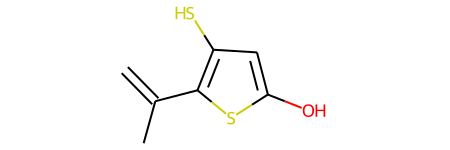

In [72]:
from rdkit.Chem.MolStandardize import rdMolStandardize
enumerator = rdMolStandardize.TautomerEnumerator()

mol = rdkit.Chem.MolFromSmiles('C=C(C)c1sc(O)cc1S')
enumerator.Canonicalize(mol)

In [63]:
from rdkit.Chem.Draw import MolsToGridImage
img = MolsToGridImage(annotated_rewards.smiles.apply(rdkit.Chem.MolFromSmiles), molsPerRow=5,
                legends=annotated_rewards.apply(lambda x: f'{x.smiles}\n#atoms={x.num_atoms}', 1).values.tolist(), 
                highlightAtomLists=[[i] for i in annotated_rewards.radical_idx],
                useSVG=True)

with open('mols.svg', 'wt') as f:
    f.write(img.data)

/home/pstjohn/mambaforge/envs/rlmol/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


In [24]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import Image

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

stability_model = tf.keras.models.load_model('/projects/rlmolecule/pstjohn/models/20210214_radical_stability_new_data/', compile=False)
from rlmolecule.molecule.policy.preprocessor import load_preprocessor

preprocessor = load_preprocessor()

In [ ]:
def pred_spins(mol):
    spins, _ = stability_model(
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in preprocessor.construct_feature_matrices(mol).items()})

    return spins.numpy().flatten()

d = rdMolDraw2D.MolDraw2DCairo(250, 250)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
Image(d.GetDrawingText())

# Leftover code from augmenting_reward branch:

In [ ]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
pass_gng.sample(10)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [ ]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
# Load the policy training history
try:
    log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
    log['time'] = pd.to_datetime(log.time)
except Exception:
    log = None

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

if log is not None:
    log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df = df.sort_values('time_hours')

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(2.75, 2.5), dpi=150)

axs[0].plot(df.time_hours, df.real_reward, '.', ms=.75, label='games')
axs[0].plot(df.time_hours, df.real_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0.3, bbox_to_anchor=(1., 1.1), markerscale=10)
axs[1].legend(ncol=2, borderpad=0, borderaxespad=0.3)

axs[0].set_ylim([0, 250])

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

axs[1].set_ylim([0, .7])
axs[1].set_xlim([-.01, 4])

plt.tight_layout()
sns.despine(offset=5, trim=True)
# plt.savefig('20210204_policy_loss.svg')

In [ ]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

In [ ]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

In [ ]:
rew_df.sort_values('real_reward', ascending=False).head(20)

In [ ]:
stable_df = pd.read_csv('/home/pstjohn/Research/20200608_redox_calculations/stable_radicals/spin-charges-bur-vol-stable-radicals-all-atoms-with-smi.csv')

stable_df_noH = stable_df[~stable_df['atom-sym-idx'].str.startswith('H')]
stable_df['fractional_spin'] = stable_df_noH.groupby('File')['spin-density'].transform(lambda x: x.abs() / x.abs().sum())

stable_idx_max_spin = stable_df.groupby('File').fractional_spin.idxmax()
stable_max_spin = stable_df.loc[stable_idx_max_spin]

In [ ]:
from rdkit import Chem

In [ ]:
stable_df['smiles'] = stable_df.Smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [ ]:
rew_df[rew_df.smiles.isin(stable_df.smiles)]

In [ ]:
pass_gng = rew_df[(rew_df.bde < 80) & (rew_df.bde > 60) &
                  (rew_df.ie < 1.2) & (rew_df.ea > -.5) &
                  ((rew_df.ie - rew_df.ea) > 1) &
                  ((rew_df.buried_vol + 50 * (1 - rew_df.max_spin)) > 100.)]

In [ ]:
pass_gng.shape

In [ ]:
pass_gng.to_csv('20210109_gng_radicals.csv.gz', compression='gzip')

In [ ]:
from reward import redox_model, predict

In [ ]:
from alphazero.node import Node

In [ ]:
import tensorflow as tf

In [ ]:
def pred_redox(smiles):
    return predict(redox_model,
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(rdkit.Chem.MolFromSmiles(smiles)).policy_inputs.items()}).numpy().flatten()

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
redox = pass_gng.smiles.progress_apply(pred_redox)

In [ ]:
plt.plot(np.vstack(redox.values)[:, 0], pass_gng.ie, '.')

In [ ]:
(pass_gng.ie - np.vstack(redox.values)[:, 0]).abs().mean()

In [ ]:
Node(rdkit.Chem.MolFromSmiles('CC(=S)C1=C(C)[CH]CCC1(C)C')).policy_inputs

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
pass_gng.sample(10)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [ ]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [ ]:
row = pass_gng.sample(1, random_state=5).iloc[0]
mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())